In [1]:
import richdem as rd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio as rio

In [2]:
Path('.')

# if Path('../../datasets')
datasets_dir = Path('../../datasets')
print(datasets_dir / 'moscow')


../../datasets/moscow


In [139]:
# elev_rio = rio.open(datasets_dir / 'moscow' / 'moscow_lidar_elevation' / 'City_of_Moscow_LiDAR.vrt')
# elev_rio = rio.open(datasets_dir / 'moscow' / 'palouse' / 'palouse_hills.tif')
elev_rio = rio.open('palouse_hills_re.tif')

# # Another option, for reading right into richdem
# elev_rd = rd.LoadGDAL('../../datasets/moscow/moscow_lidar_elevation/City_of_Moscow_LiDAR.vrt')

In [140]:
elev_rio

<open DatasetReader name='palouse_hills_re.tif' mode='r'>

We use the `read` function to read in the data that is contained within our raster.
We also need to give the band number of the data (many datasets can contain multiple bands).
Do you know an example of a raster dataset with multiple bands?  Google for it if necessary.

Because rasterio makes significant use of the open source geospatial tool, gdal (https://gdal.org/),
the band numbers for reading raster data start at 1, not at 0, as they ought to in python.
gdal is a part of a lot of different tools, in a lot of different programming languages, not just python, 
so this component of rasterio is pretty odd from the perspective of a pythonist(a/o).

In [141]:
elev = elev_rio.read(1)

The elevation data are in a rectangular grid, and can be viewed as a numpy array

In [142]:
print(type(elev))
print()
elev

<class 'numpy.ndarray'>



array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

Set the elevations less than -1000 m to np.nan.

In [143]:
elev[elev<-1000] = np.nan

In [144]:
elev # Confirm that the replacements took place


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

What are the units of these elevations?  You'll have to refer to the pdf documentation that came with this elevation dataset.

What is the size/shape of this elevation dataset?

Read the rasterio manual section on Georeferencing: https://rasterio.readthedocs.io/en/latest/topics/georeferencing.html

What are the two metadata components that allow us to place a grid of data in space?
Describe in your own language what their purpose is and how they are represented.

In [145]:
# dir(elev_rio)
# elev_rio.units
print(elev_rio.crs)

elev_rio.transform # The `transform` orients the raster grid in space relative to the crs.
    # The crs contains the units and identifies where the (0, 0) point of the grid ought to be in space.

EPSG:6340


Affine(7.985284601113701, 0.0, 477366.21453214076,
       0.0, -7.985284601113701, 5186901.819175103)

We see above that this dataset has a Coordinate Reference System EPSG code of 6340.
That is enough information to transform different kinds of data to ensure that they are in the same coordinate
reference system and therefore can be plotted and analyzed together.  Hypothetically, you could then 
look up this epsg to get more information about it, e.g., https://epsg.org/.

But we can get more information about the crs by relying on its "Well Known Text", or `wkt`.

In [19]:
elev_rio.crs.wkt

'PROJCS["NAD_1983_2011_UTM_Zone_11N",GEOGCS["NAD83(2011)",DATUM["NAD83_National_Spatial_Reference_System_2011",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6318"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6340"]]'

What reference frame and what units are the horizontal coordinates in?

We can use the `transform` field to pull some important information about the raster data, critically, including the 
x and y locations of the raster.


In [21]:
dx = elev_rio.transform[0] # grid resolution in Easting (x)
rast_x = elev_rio.transform[2] + dx * np.arange(elev_rio.width)
dy = elev_rio.transform[4] # grid resolution in Northing (y)
rast_y = elev_rio.transform[5] + dy * np.arange(elev_rio.height)


In [22]:
dx # grid resolution in Easting (x)

0.5

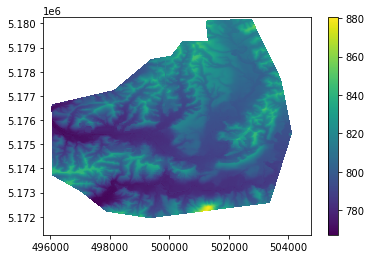

In [23]:
fig, ax = plt.subplots()
elev_ax = ax.pcolormesh(rast_x, rast_y, elev, shading='auto')
plt.colorbar(elev_ax, ax=ax)

In [146]:
elev_rd = rd.rdarray(elev, no_data=np.nan) # Need to turn the elevations from a numpy array to an rdarray to handle the np.nan values
# elev_rd.projection = 6340
# Be careful!  The richdem geotransform has a different configuration than the rasterio transform.
    # The geotransform must be a tuple.
elev_rd.geotransform = (elev_rio.transform[2],
                        elev_rio.transform[0],
                        elev_rio.transform[1],
                        elev_rio.transform[5],
                        elev_rio.transform[3],
                        elev_rio.transform[4])

# slope = rd.TerrainAttribute(elev_rd, attrib='slope_riserun')
slope = rd.TerrainAttribute(elev_rd, attrib='slope_degrees')


A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.813196======================= ] (99% - 0.0s - 1 threads)                    ] (25% - 0.6s - 1 threads)


In [147]:
print(elev_rd.geotransform)

(477366.21453214076, 7.985284601113701, 0.0, 5186901.819175103, 0.0, -7.985284601113701)


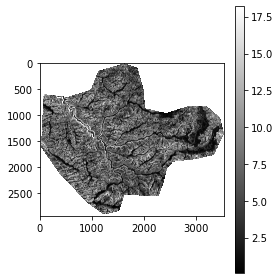

{'vmin': 0.11240037530660628, 'vmax': 18.197691726684567}

In [148]:
# When you just create `slope`, it is an rdarray, but without any transform information
rd.rdShow(slope)

In [149]:
aspect = rd.TerrainAttribute(elev_rd, attrib='aspect')

aspect.geotransform = elev_rd.geotransform


A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 2.85744======================== ] (99% - 0.0s - 1 threads)=========================             ] (74% - 0.7s - 1 threads)


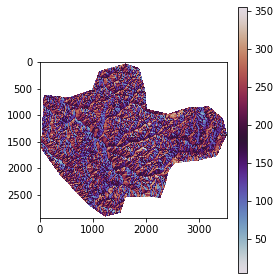

{'vmin': 5.514099788665771, 'vmax': 354.8293347167969}

In [150]:
rd.rdShow(aspect, cmap='twilight')

(array([1528., 1404., 1261., 1194., 1128., 1013., 1032.,  967.,  855.,
         762.,  734.,  726.,  641.,  610.,  572.,  522.,  506.,  472.,
         435.,  417.,  415.,  374.,  336.,  351.,  345.,  289.,  324.,
         293.,  264.,  296.,  325.,  348.,  318.,  381.,  373.,  392.,
         426.,  426.,  502.,  506.,  500.,  548.,  549.,  525.,  522.,
         505.,  494.,  466.,  432.,  376.,  348.,  343.,  321.,  262.,
         224.,  212.,  192.,  185.,  185.,  179.,  188.,  181.,  166.,
         172.,  147.,  177.,  119.,  147.,  139.,  132.,  135.,  153.,
         139.,  165.,  156.,  157.,  197.,  206.,  192.,  215.,  238.,
         278.,  305.,  322.,  289.,  304.,  347.,  303.,  351.,  354.,
         372.,  342.,  303.,  292.,  253.,  230.,  196.,  193.,  144.,
         152.,  136.,  129.,  134.,  133.,  134.,  127.,  120.,  114.,
         112.,  113.,  103.,   81.,   92.,   99.,   88.,   99.,   69.,
          92.,   81.,  111.,  104.,  113.,   95.,  108.,  113.,  127.,
      

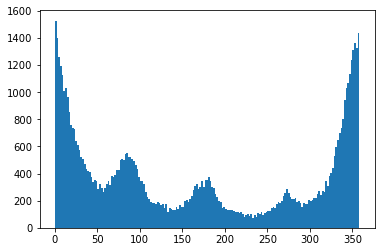

In [152]:
plt.hist( aspect[slope>20] , bins = np.arange(0, 360, 2) )

In [ ]:
elev

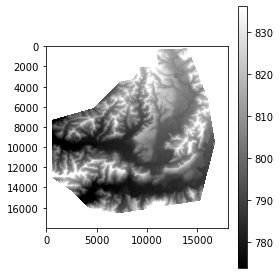

{'vmin': 773.839599609375, 'vmax': 836.2122802734375}

In [25]:
rd.rdShow(elev)

In [26]:
slope = rd.TerrainAttribute(elev, attrib='slope_riserun')


A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 9.6264                          ] (6% - 150.7s - 1 threads)                    ] (9% - 11.4s - 1 threads)


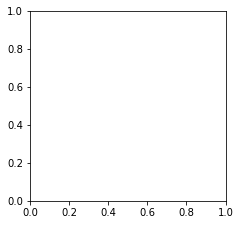

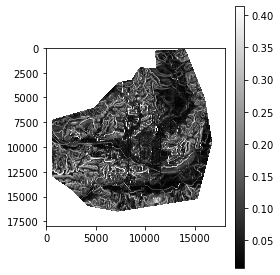

{'vmin': 0.007452821359038353, 'vmax': 0.41384343564510306}

In [27]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
rd.rdShow(slope)#, ax=ax)

In [99]:
rd.rdShow?

Signature:
rd.rdShow(
    rda,
    ignore_colours=[],
    show=True,
    axes=True,
    cmap='gray',
    vmin=None,
    vmax=None,
    xmin=None,
    xmax=None,
    ymin=None,
    ymax=None,
    zxmin=None,
    zxmax=None,
    zymin=None,
    zymax=None,
    figsize=(4, 4),
    zcolor='red',
    zloc=1,
)
Docstring: <no docstring>
File:      ~/anaconda3/envs/GISenv21b/lib/python3.9/site-packages/richdem/__init__.py
Type:      function


In [100]:
slope.shape

(18000, 18000)

In [101]:
elev.shape

(18000, 18000)

How different are the slopes calculated in the Moscow area when you use 
the 1/3 arc second dataset from the USGS National Elevation Database, versus
the lidar dataset?


In [120]:
elev_rio.crs

CRS.from_epsg(4269)

NameError: name 'cwd' is not defined

In [138]:


# Instructions from https://rasterio.readthedocs.io/en/latest/topics/reproject.html#reprojecting-a-geotiff-dataset

def reproject_basic(input_file, output_file, dst_crs):
    import numpy as np
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling

    with rasterio.open(input_file) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)


In [ ]:
reproject_basic('../../datasets/moscow/palouse/palouse_hills.tif',
                'palouse_hills_re.tif',
                'EPSG:6340')

In [126]:
%pwd

'/Users/timb/syncs/OneDrive - University of Idaho/TEACHINGs/GEOG479_GIS_programming/GIS_programming_F21/weeks/wk06_rasters_intro'